In [1]:
cd ../..

D:\Code\Datajoint\orofacial_pipeline


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pipeline import lab, experiment, ephys, tracking

Connecting vincent@datajoint-db.orofacial-sensorimotor-circuits.org:3306


# Overview plot

### An overall summary plot of behavior, tracking, and spiking activity for a particular session

In [4]:
session_key = {'subject_id': 'vIRt47', 'session': 20}

In [5]:
experiment.Session & session_key

*subject_id    *session    session_date   session_time   session_basena username     rig           
+------------+ +---------+ +------------+ +------------+ +------------+ +----------+ +------------+
vIRt47         20          2020-08-05     13:52:38       vIRt47_0805_57 vincent      vincent_ephys_
 (Total: 1)

In [6]:
experiment.BehaviorTrial & session_key

*subject_id    *session    *trial    task     task_protocol 
+------------+ +---------+ +-------+ +------+ +------------+

 (Total: 0)

## Extract whisker tracking data

In [7]:
tracking.Tracking.WhiskerTracking & session_key

*subject_id    *session    *tracking_devi *whisker_idx   angle      curvature  face_x     face_y     follicle_x follicle_y tip_x      tip_y     
+------------+ +---------+ +------------+ +------------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+
vIRt47         20          WT_Camera_Vinc 0              =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
vIRt47         20          WT_Camera_Vinc 1              =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
vIRt47         20          WT_Camera_Vinc 2              =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
 (Total: 3)

In [8]:
device_key = {'tracking_device': 'WT_Camera_Vincent 0'}

In [9]:
tracking_timestamps = (tracking.Tracking & session_key & device_key).fetch1('tracking_timestamps')

In [10]:
tracking_timestamps

array([   5.82490015,    5.82590015,    5.82690015, ..., 1454.78590015,
       1454.78690015, 1454.78790015])

In [11]:
whiskers, whisker_angles = (tracking.Tracking.WhiskerTracking & session_key & device_key).fetch(
    'whisker_idx', 'angle', order_by='whisker_idx')

In [12]:
whiskers

array([0, 1, 2], dtype=int64)

In [13]:
whisker_angles

array([array([-111.70805565, -110.45121536, -109.18448839, ..., -137.34187554,
       -137.32554315, -137.31165214]),
       array([-101.08147179, -100.27671476,  -99.48490388, ..., -130.2681879 ,
       -130.26209308, -130.25752372]),
       array([ -98.94571638,  -98.13076038,  -97.30648407, ..., -125.5577779 ,
       -125.5613677 , -125.56433748])], dtype=object)

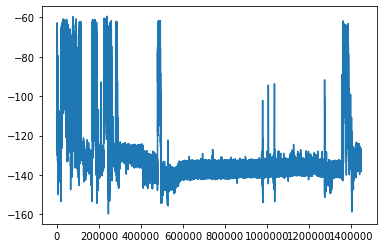

In [14]:
plt.plot(whisker_angles[1])

In [15]:
whisker_phase = (tracking.ProcessedWhisker & session_key & device_key).fetch(
    'phase', order_by='whisker_idx')

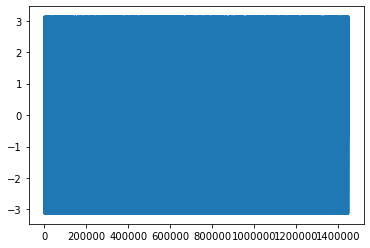

In [16]:
plt.plot(whisker_phase[1])

## Extract units' spiketimes

In [17]:
ephys.Unit & session_key

*subject_id    *session    *insertion_num *clustering_me *unit    unit_quality   probe_type     electrode_conf electrode_grou electrode     unit_posx      unit_posy      spike_time spike_site spike_dept unit_amp      unit_snr    
+------------+ +---------+ +------------+ +------------+ +------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +--------+ +--------+ +--------+ +-----------+ +----------+
vIRt49         1           0              jrclust_v4     1        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              1             1.336154222488 2.766973972320 =BLOB=     =BLOB=     =BLOB=     282.38644     nan         
vIRt49         1           0              jrclust_v4     2        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              2             17.20083427429 14.64715766906 =BLOB=     =BLOB=     =BLOB=     211.8829      nan         
vIRt49         1           0              jrclust_v4     3        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              2             17.93284797668 16.78452491760 =BLOB=     =BLOB=     =BLOB=     136.88995     nan         
vIRt49         1           0              jrclust_v4     4        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              2             13.52094936370 17.73533439636 =BLOB=     =BLOB=     =BLOB=     159.24747     nan         
vIRt49         1           0              jrclust_v4     5        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              4             21.20494079589 31.72251510620 =BLOB=     =BLOB=     =BLOB=     135.57997     nan         
vIRt49         1           0              jrclust_v4     6        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              5             1.315775513648 47.70310592651 =BLOB=     =BLOB=     =BLOB=     121.28857     nan         
vIRt49         1           0              jrclust_v4     7        all            CNT ASSY-37 P2 CNT ASSY-37 P2 0              5             6.527263164520 50.14341354370 =BLOB=     =BLOB=     =BLOB=     415.30737     nan         
   ...
 (Total: 73)

In [18]:
insertion_keys = (ephys.ProbeInsertion & session_key).fetch('KEY')

In [19]:
insertion_keys

[{'subject_id': 'vIRt49', 'session': 1, 'insertion_number': 0}]

In [67]:
spike_rasters = {}
for insertion_key in insertion_keys:
    units, spikes = (ephys.Unit & insertion_key).fetch('unit', 'spike_times')
    
    # concatenating spiketimes from all units into a 1d-vector
    spike_vec = np.concatenate(spikes)  
    
    # build a 1d-vector of equal length, representing the corresponding unit number for each spike in the "spike_vec"
    unit_vec = np.concatenate([[t] * len(s) for s, t in zip(spikes, unit)])
    
    # store in the "spike_rasters" with the insertion_number as key
    spike_rasters[insertion_key['insertion_number']] = {'spike_vec': spike_vec, 'unit_vec': unit_vec}

In [68]:
spike_rasters

{0: {'spike_vec': array([6.69333333e-02, 8.71000000e-02, 1.04700000e-01, ...,
         4.72146767e+02, 4.72349433e+02, 4.72388167e+02]),
  'unit_vec': array([ 1,  1,  1, ..., 73, 73, 73], dtype=int64)}}

## PLOT

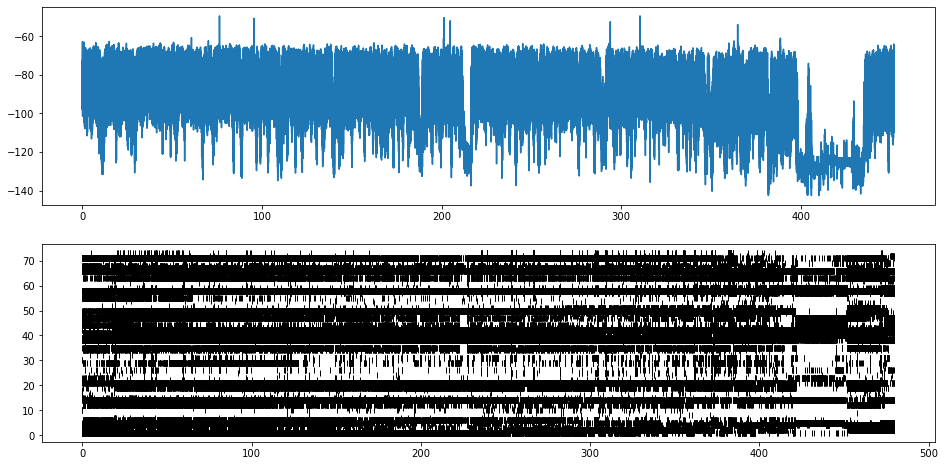

In [69]:
fig, axes = plt.subplots(len(spike_rasters) + 1, 1, figsize=(16, 8))

# plot whisker angle in the first subplot
axes[0].plot(tracking_timestamps, whisker_angles[0])

# plot spike raster in the remaining subplots, one per probe
for insertion_num, ax in zip(spike_rasters, axes[1:]):
    ax.plot(spike_rasters[insertion_num]['spike_vec'], spike_rasters[insertion_num]['unit_vec'], 'k|')

## Example segmentation by trial

In [41]:
experiment.BehaviorTrial * experiment.SessionTrial & session_key

*subject_id    *session    *trial    task         task_protocol  start_time     stop_time    
+------------+ +---------+ +-------+ +----------+ +------------+ +------------+ +-----------+
vIRt49         1           0         hf wheel     0              0.0000         372.6174     
vIRt49         1           1         hf wheel     0              372.6174       431.5374     
vIRt49         1           2         hf wheel     0              431.5374       479.5032     
 (Total: 3)

### fetch back the start and stop times of all trials in this session

In [70]:
trial_starts, trial_stops = (experiment.BehaviorTrial * experiment.SessionTrial & session_key).fetch('start_time', 'stop_time')

In [43]:
trial_starts

array([Decimal('0.0000'), Decimal('372.6174'), Decimal('431.5374')],
      dtype=object)

In [44]:
trial_stops

array([Decimal('372.6174'), Decimal('431.5374'), Decimal('479.5032')],
      dtype=object)

### extract the whisker angle data from the last trial only

In [71]:
in_trial = np.logical_and(tracking_timestamps >= trial_starts[-1], tracking_timestamps < trial_stops[-1])

In [72]:
trial_timestamps = tracking_timestamps[in_trial]
trial_whisker = whisker_angles[1][in_trial]

In [73]:
trial_timestamps

array([431.538, 431.54 , 431.542, ..., 462.918, 462.92 , 462.922])

In [74]:
trial_whisker

array([-65.57880402, -63.64982224, -63.00873947, ...,          nan,
                nan,          nan])

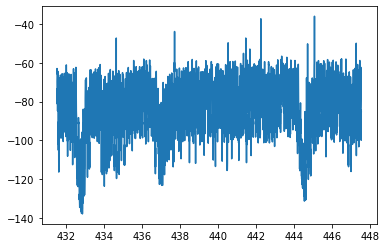

In [75]:
plt.plot(trial_timestamps, trial_whisker)

### extract the unit spiketimes from the last trial only

In [62]:
units, spikes, waveforms = (ephys.Unit * ephys.Unit.Waveform & insertion_key).fetch('unit', 'spike_times', 'waveform')

In [53]:
units

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73], dtype=int64)

In [79]:
unit_spikes = spikes[5]  # select spike times from unit #5

In [80]:
unit_spikes

array([2.55533333e-01, 2.82800000e-01, 3.16766667e-01, ...,
       4.36291633e+02, 4.37879000e+02, 4.53534667e+02])

In [81]:
in_trial = np.logical_and(unit_spikes >= trial_starts[-1], unit_spikes < trial_stops[-1])

In [82]:
trial_spikes = unit_spikes[in_trial]

In [83]:
trial_spikes

array([432.71416667, 432.8324    , 432.8684    , 432.89853333,
       432.92276667, 433.06416667, 436.29163333, 437.879     ,
       453.53466667])

### PLOT

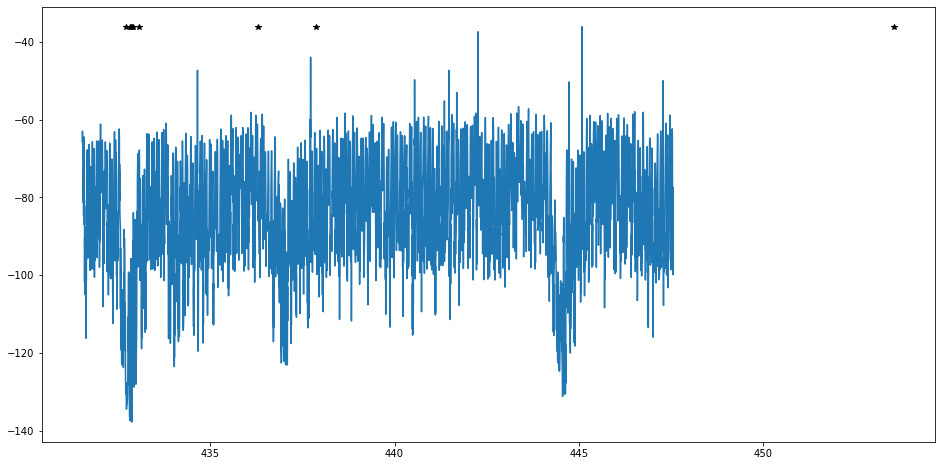

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(trial_timestamps, trial_whisker)
ax.plot(trial_spikes, np.full_like(trial_spikes, np.nanmax(trial_whisker)), 'k*')